<a href="https://colab.research.google.com/github/fjadidi2001/Insurance/blob/main/ClaimYNprediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Load the dataset

In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# Load the dataset from Google Drive
file_path = '/content/drive/My Drive/Insurance/telematics_syn.csv'
df = pd.read_csv(file_path)

Mounted at /content/drive


In [ ]:
df.head()

,Duration,Insured.age,Insured.sex,Car.age,Marital,Car.use,Credit.score,Region,Annual.miles.drive,Years.noclaims,...,Left.turn.intensity10,Left.turn.intensity11,Left.turn.intensity12,Right.turn.intensity08,Right.turn.intensity09,Right.turn.intensity10,Right.turn.intensity11,Right.turn.intensity12,NB_Claim,AMT_Claim
0,366,45,Male,-1,Married,Commute,609.0,Urban,6213.71,25,...,1.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,1,5100.171753
1,182,44,Female,3,Married,Commute,575.0,Urban,12427.42,20,...,58.0,24.0,11.0,1099.0,615.0,219.0,101.0,40.0,1,883.554840
2,184,48,Female,6,Married,Commute,847.0,Urban,12427.42,14,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000
3,183,71,Male,6,Married,Private,842.0,Urban,6213.71,43,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.000000
4,183,84,Male,10,Married,Private,856.0,Urban,6213.71,65,...,2.0,0.0,0.0,325.0,111.0,18.0,4.0,2.0,0,0.000000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Duration                100000 non-null  int64  
 1   Insured.age             100000 non-null  int64  
 2   Insured.sex             100000 non-null  object 
 3   Car.age                 100000 non-null  int64  
 4   Marital                 100000 non-null  object 
 5   Car.use                 100000 non-null  object 
 6   Credit.score            100000 non-null  float64
 7   Region                  100000 non-null  object 
 8   Annual.miles.drive      100000 non-null  float64
 9   Years.noclaims          100000 non-null  int64  
 10  Territory               100000 non-null  int64  
 11  Annual.pct.driven       100000 non-null  float64
 12  Total.miles.driven      100000 non-null  float64
 13  Pct.drive.mon           100000 non-null  float64
 14  Pct.drive.tue        

# Step 2: Data Preprocessing


In [ ]:
# Derive the target variable
df['ClaimYN'] = ((df['NB_Claim'] >= 1) & (df['AMT_Claim'] > 1000)).astype(int)

# Drop unnecessary columns
df = df.drop(['NB_Claim', 'AMT_Claim'], axis=1)

# Handle missing values (if any)
df = df.dropna()

# Encode categorical variables
df = pd.get_dummies(df, drop_first=True)

# Separate features and target variable
X = df.drop('ClaimYN', axis=1)
y = df['ClaimYN']

# Normalize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [ ]:
df.head()

,Duration,Insured.age,Car.age,Credit.score,Annual.miles.drive,Years.noclaims,Territory,Annual.pct.driven,Total.miles.driven,Pct.drive.mon,...,Right.turn.intensity10,Right.turn.intensity11,Right.turn.intensity12,ClaimYN,Insured.sex_Male,Marital_Single,Car.use_Commute,Car.use_Farmer,Car.use_Private,Region_Urban
0,366,45,-1,609.0,6213.71,25,70,0.849315,8864.376247,0.148070,...,0.0,0.0,0.0,1,True,False,True,False,False,True
1,182,44,3,575.0,12427.42,20,26,0.465753,8092.308208,0.147686,...,219.0,101.0,40.0,0,False,False,True,False,False,True
2,184,48,6,847.0,12427.42,14,84,0.520548,3225.832512,0.153735,...,0.0,0.0,0.0,0,False,False,True,False,False,True
3,183,71,6,842.0,6213.71,43,30,0.065753,253.024528,0.106702,...,0.0,0.0,0.0,0,True,False,False,False,True,True
4,183,84,10,856.0,6213.71,65,70,0.441096,4374.379634,0.123807,...,18.0,4.0,2.0,0,True,False,False,False,True,True


In [ ]:
# Access the 'ClaimYN' column from the DataFrame 'df'
df['ClaimYN'].describe()  # Use .describe() for distribution statistics

# Or, if you want the ClaimYN Series:
ClaimYN_series = df['ClaimYN']
ClaimYN_series.describe()

,ClaimYN
count,100000.000000
mean,0.026980
std,0.162026
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


# Step 3: Handle Class Imbalance


In [ ]:
# Use SMOTE to handle class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

# Display class distribution after SMOTE
print("Class distribution after SMOTE:")
print(y_resampled.value_counts())


Class distribution after SMOTE:
ClaimYN
1    97302
0    97302
Name: count, dtype: int64


# Step 4: Create the model

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Create a Gradient Boosting model (alternative to XGBoost)
gb_model = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

# Create a Neural Network model (alternative to TabNet)
nn_model = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

# Train both models
gb_model.fit(X_train, y_train)
nn_model.fit(X_train, y_train)

# Make predictions using both models
gb_pred_proba = gb_model.predict_proba(X_test)[:, 1]
nn_pred_proba = nn_model.predict_proba(X_test)[:, 1]

# Combine predictions (simple average ensemble)
ensemble_pred_proba = (gb_pred_proba + nn_pred_proba) / 2
ensemble_predictions = (ensemble_pred_proba > 0.5).astype(int)



Gradient Boosting Performance Metrics:
Accuracy: 0.9561
Precision: 0.9597
Recall: 0.9528
F1 Score: 0.9562
AUC-ROC: 0.9919

Neural Network Performance Metrics:
Accuracy: 0.9847
Precision: 0.9741
Recall: 0.9960
F1 Score: 0.9849
AUC-ROC: 0.9941

Ensemble Performance Metrics:
Accuracy: 0.9876
Precision: 0.9780
Recall: 0.9978
F1 Score: 0.9878
AUC-ROC: 0.9991


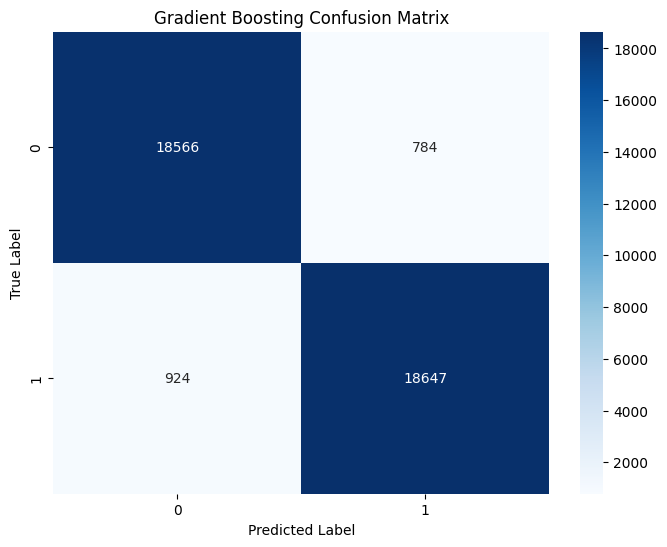

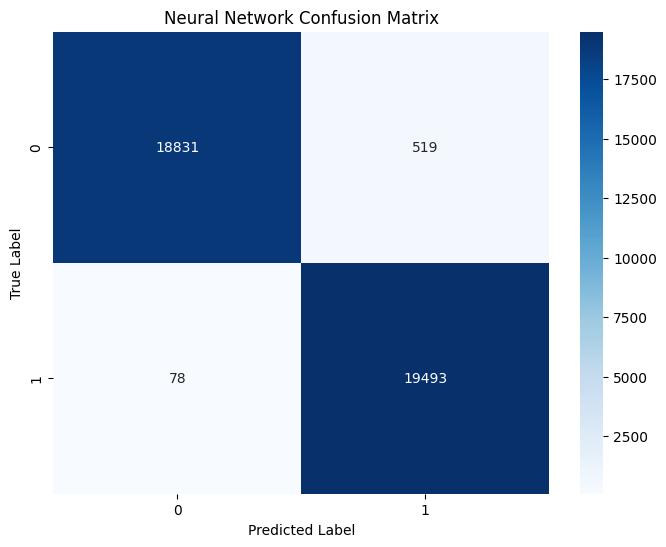

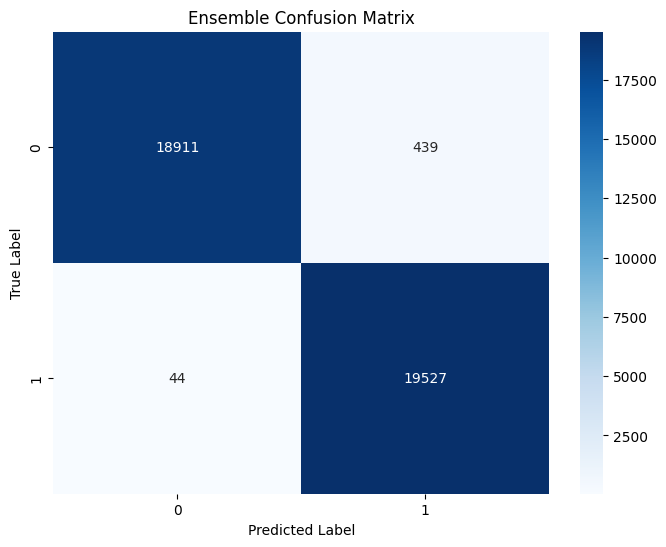

In [ ]:
def evaluate_model(y_true, y_pred, y_pred_proba, model_name):
    """
    Evaluate model performance using multiple metrics
    """
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc_roc = roc_auc_score(y_true, y_pred_proba)

    print(f"\n{model_name} Performance Metrics:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"AUC-ROC: {auc_roc:.4f}")

    return accuracy, precision, recall, f1, auc_roc

def plot_confusion_matrix(y_true, y_pred, model_name):
    """
    Plot confusion matrix
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Evaluate individual models
gb_predictions = (gb_pred_proba > 0.5).astype(int)
nn_predictions = (nn_pred_proba > 0.5).astype(int)

# Evaluate all models
evaluate_model(y_test, gb_predictions, gb_pred_proba, "Gradient Boosting")
evaluate_model(y_test, nn_predictions, nn_pred_proba, "Neural Network")
evaluate_model(y_test, ensemble_predictions, ensemble_pred_proba, "Ensemble")

# Plot confusion matrices
plot_confusion_matrix(y_test, gb_predictions, "Gradient Boosting")
plot_confusion_matrix(y_test, nn_predictions, "Neural Network")
plot_confusion_matrix(y_test, ensemble_predictions, "Ensemble")



# Flowchart

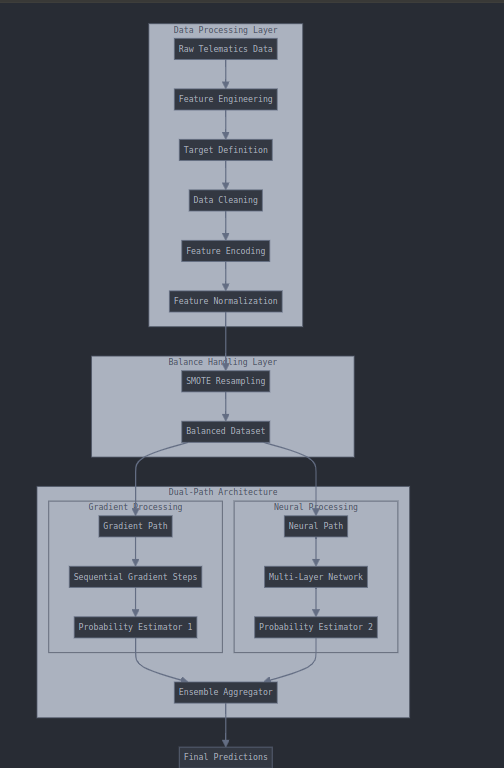

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
from sklearn.calibration import calibration_curve

def enhanced_model_evaluation(y_true, y_pred_proba, model_name):
    """
    Comprehensive model evaluation framework with advanced visualizations
    """
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(20, 12))

    # 1. ROC Curve
    ax1 = plt.subplot(231)
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    ax1.plot(fpr, tpr, label=f'ROC (AUC = {roc_auc_score(y_true, y_pred_proba):.3f})')
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curve')
    ax1.legend()

    # 2. Precision-Recall Curve
    ax2 = plt.subplot(232)
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    ap = average_precision_score(y_true, y_pred_proba)
    ax2.plot(recall, precision, label=f'PR (AP = {ap:.3f})')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curve')
    ax2.legend()

    # 3. Model Calibration Plot
    ax3 = plt.subplot(233)
    prob_true, prob_pred = calibration_curve(y_true, y_pred_proba, n_bins=10)
    ax3.plot(prob_pred, prob_true, marker='o')
    ax3.plot([0, 1], [0, 1], 'k--')
    ax3.set_xlabel('Predicted Probability')
    ax3.set_ylabel('True Probability')
    ax3.set_title('Calibration Plot')

    # 4. Probability Distribution
    ax4 = plt.subplot(234)
    sns.kdeplot(data=y_pred_proba[y_true == 0], label='No Claim', ax=ax4)
    sns.kdeplot(data=y_pred_proba[y_true == 1], label='Claim', ax=ax4)
    ax4.set_xlabel('Predicted Probability')
    ax4.set_ylabel('Density')
    ax4.set_title('Prediction Distribution by Class')
    ax4.legend()

    # 5. Threshold Analysis
    ax5 = plt.subplot(235)
    thresholds = np.linspace(0, 1, 100)
    metrics = []
    for threshold in thresholds:
        y_pred = (y_pred_proba >= threshold).astype(int)
        precision = precision_score(y_true, y_pred)
        recall = recall_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred)
        metrics.append([precision, recall, f1])

    metrics = np.array(metrics)
    ax5.plot(thresholds, metrics[:, 0], label='Precision')
    ax5.plot(thresholds, metrics[:, 1], label='Recall')
    ax5.plot(thresholds, metrics[:, 2], label='F1')
    ax5.set_xlabel('Threshold')
    ax5.set_ylabel('Score')
    ax5.set_title('Threshold Impact Analysis')
    ax5.legend()

    # 6. Confusion Matrix with Percentages
    ax6 = plt.subplot(236)
    y_pred = (y_pred_proba >= 0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=ax6)
    ax6.set_xlabel('Predicted Label')
    ax6.set_ylabel('True Label')
    ax6.set_title('Normalized Confusion Matrix')

    plt.tight_layout()
    plt.suptitle(f'{model_name} Performance Analysis', y=1.02, fontsize=16)

    return fig

# Usage function for all models
def evaluate_all_models(y_test, gb_pred_proba, nn_pred_proba, ensemble_pred_proba):
    models = {
        'Gradient Path': gb_pred_proba,
        'Neural Path': nn_pred_proba,
        'Ensemble Model': ensemble_pred_proba
    }

    for model_name, pred_proba in models.items():
        fig = enhanced_model_evaluation(y_test, pred_proba, model_name)
        plt.show()

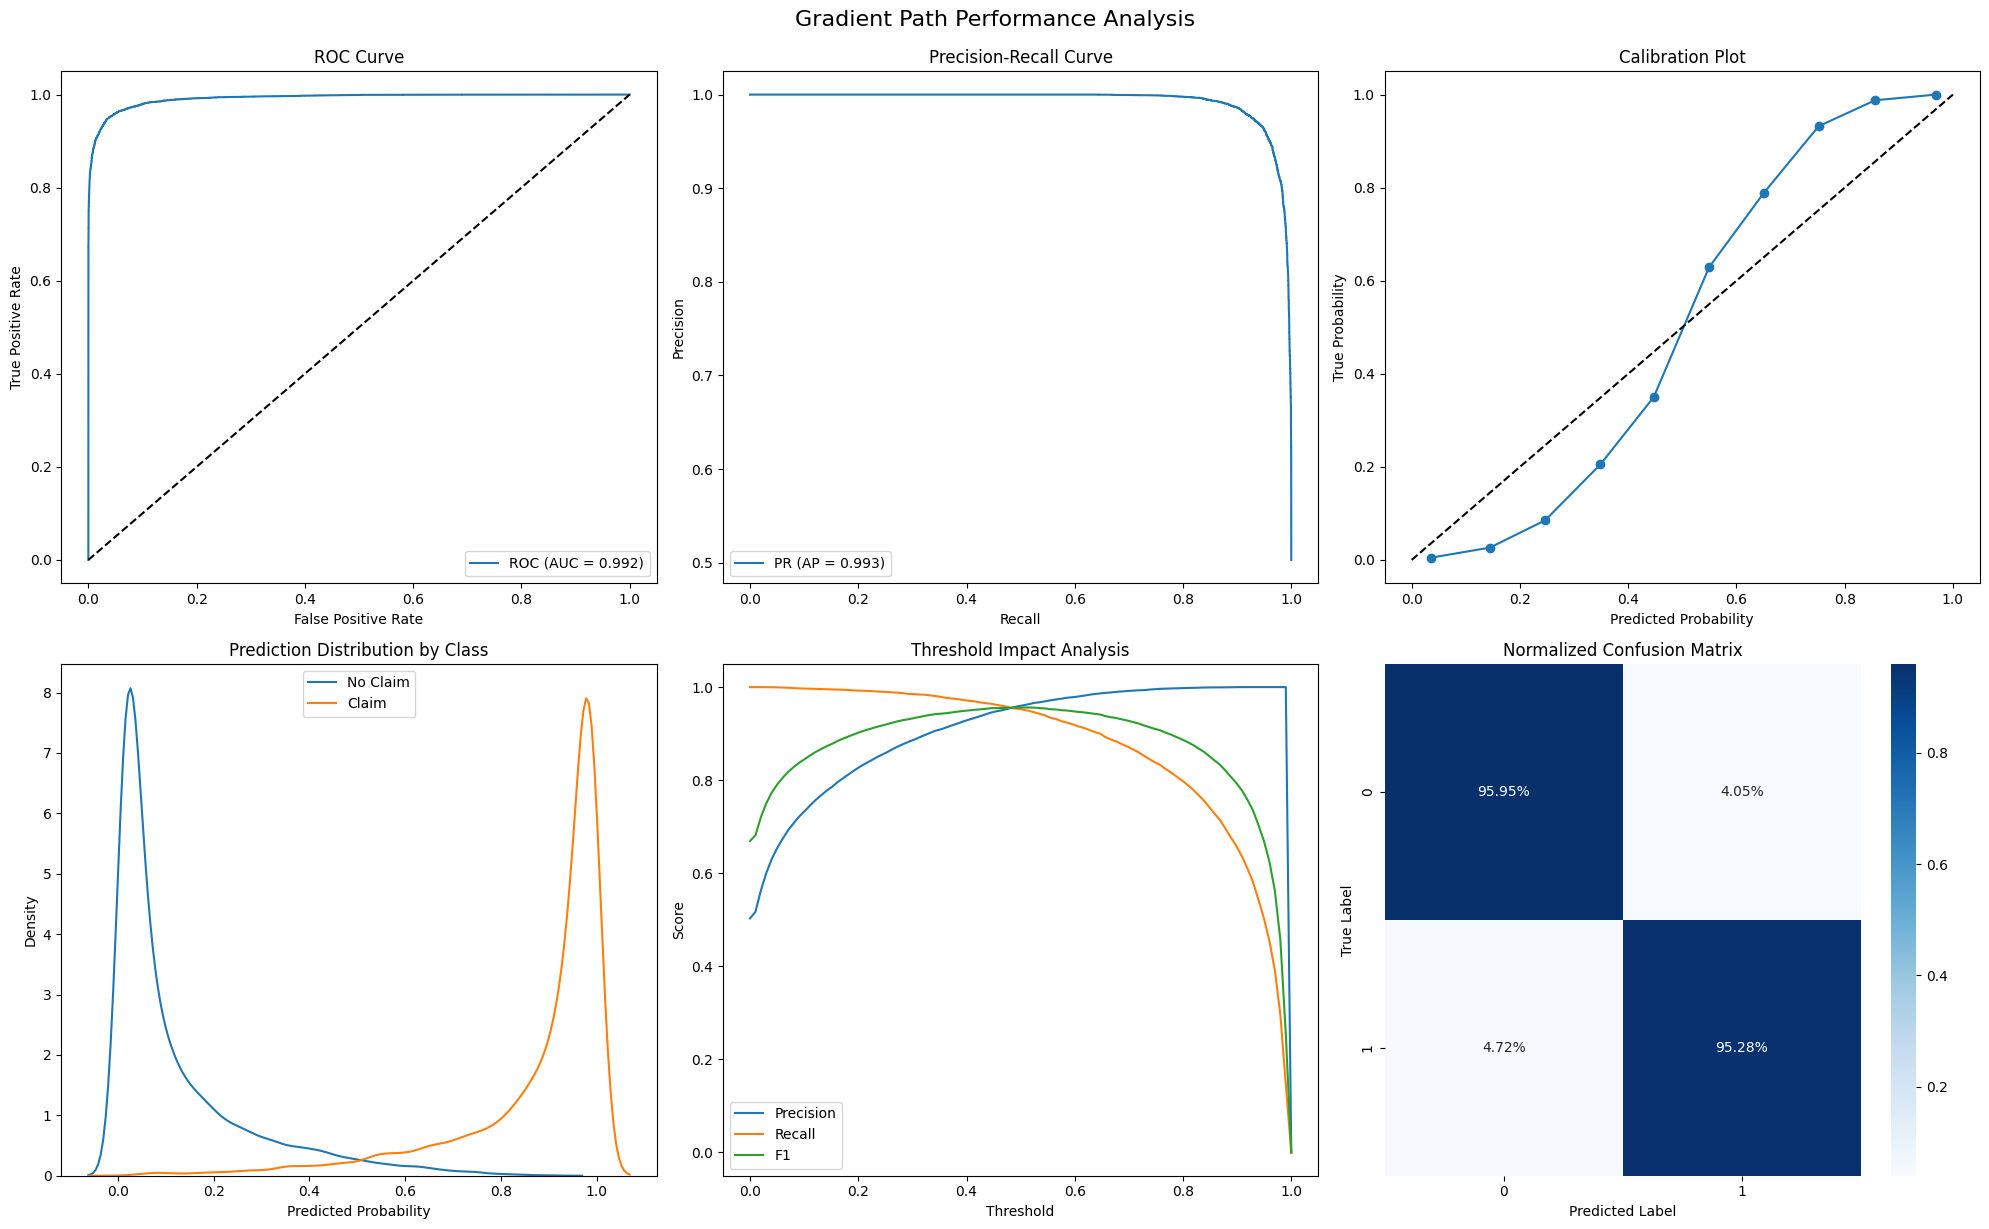

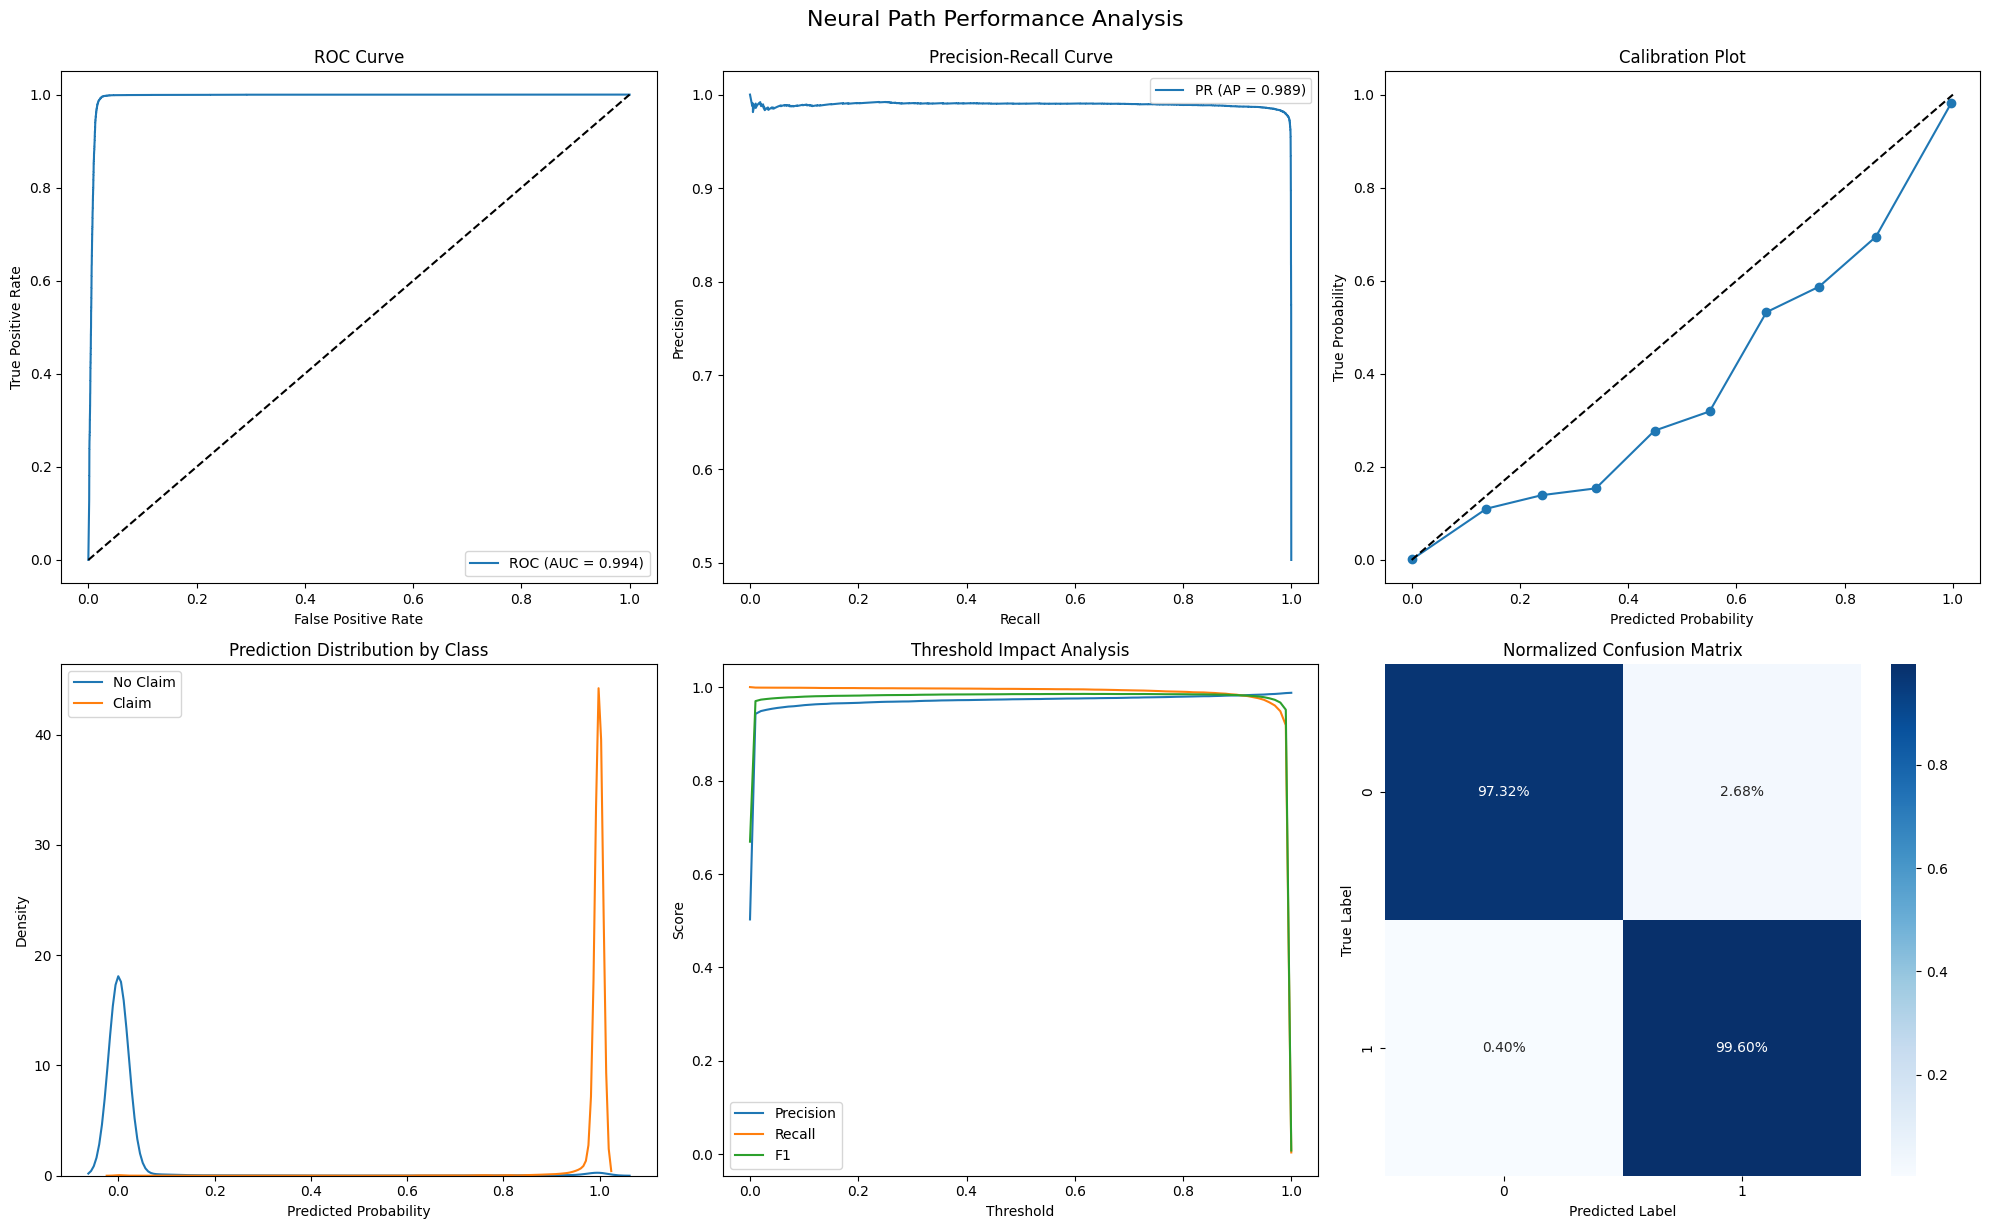

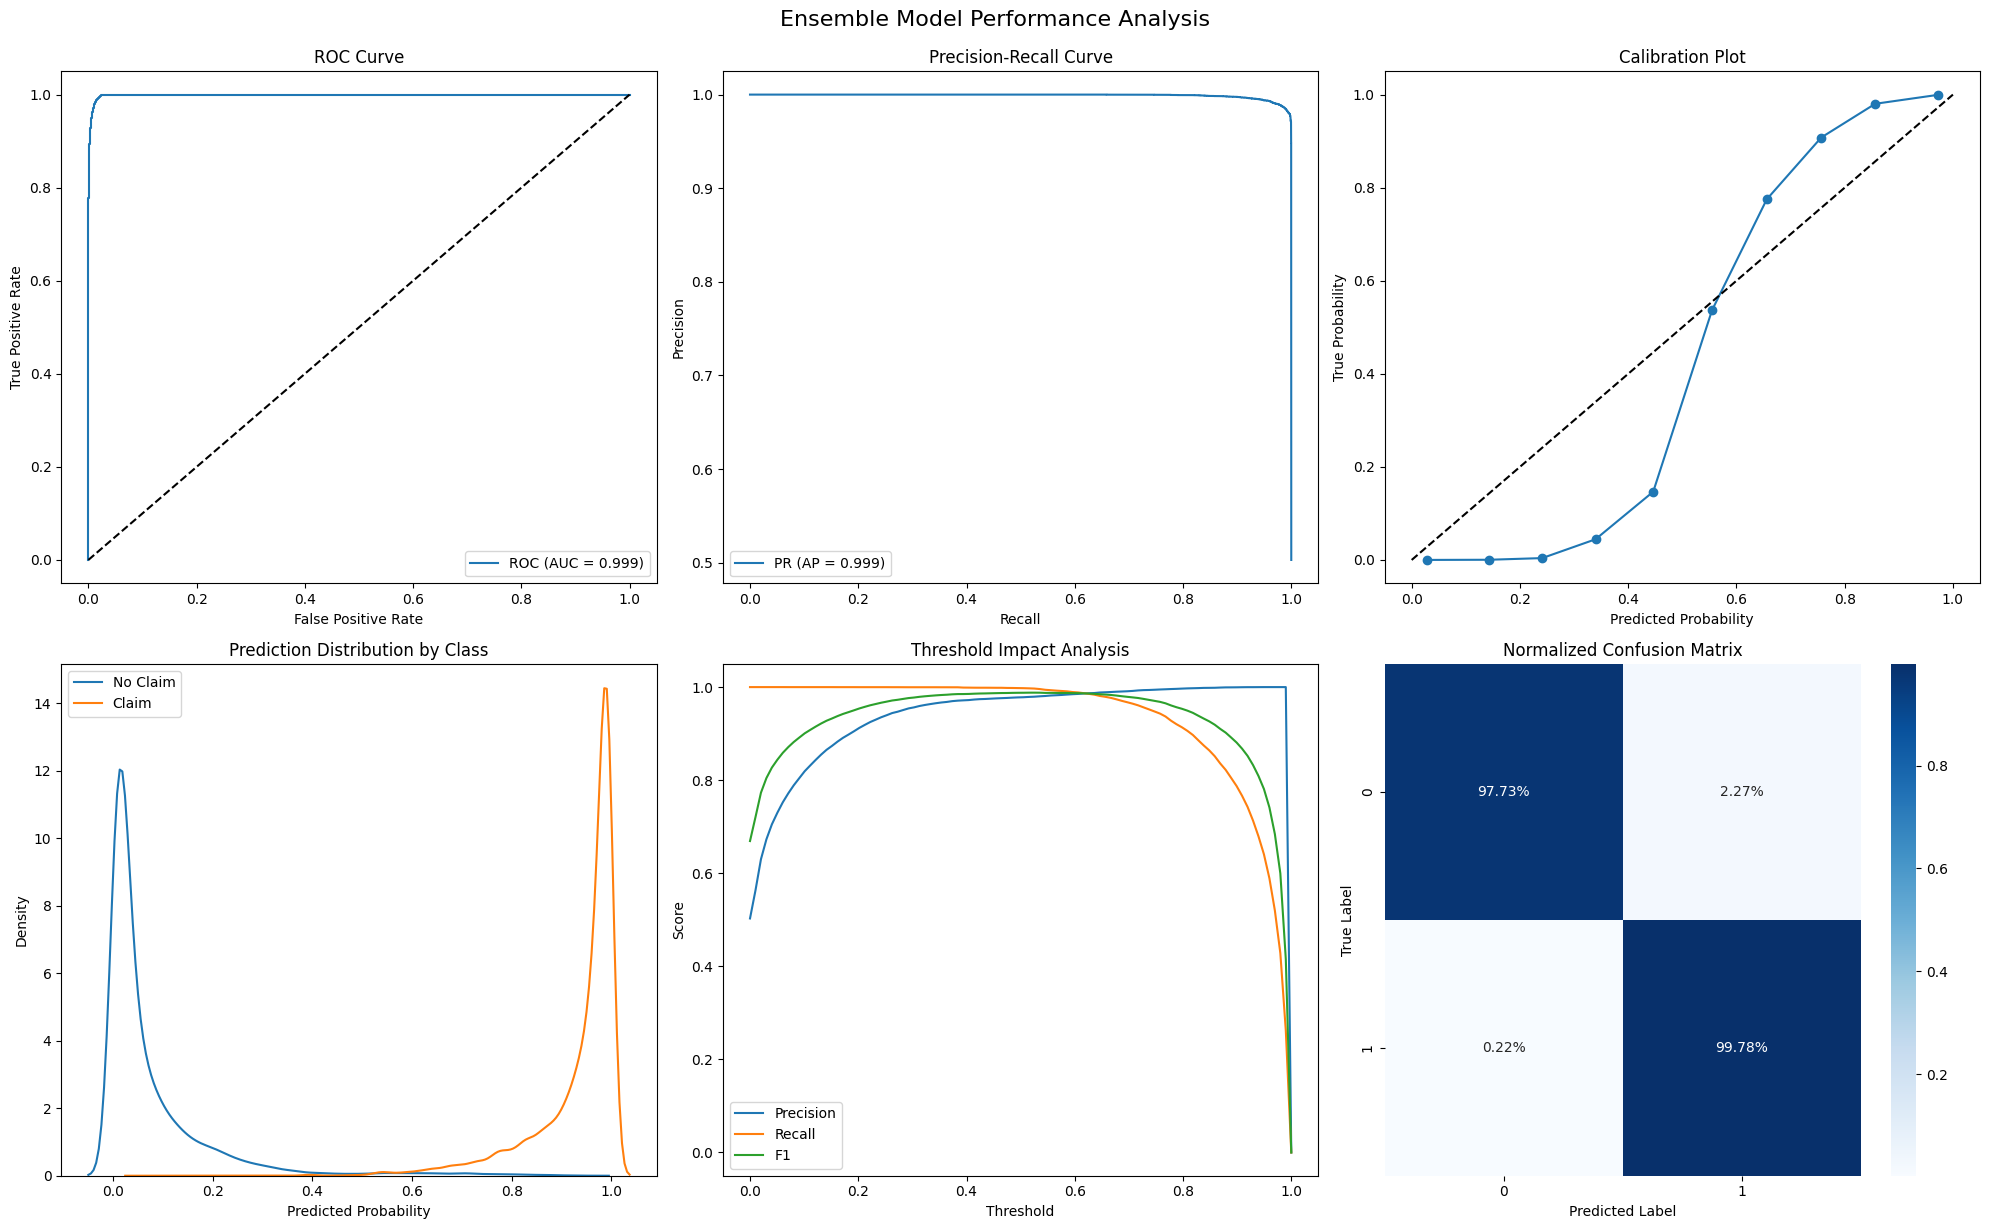

In [ ]:
evaluate_all_models(y_test, gb_pred_proba, nn_pred_proba, ensemble_pred_proba)

In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=01f44d4236a1bd4d4216e0bf8f2b8c5ccaf8a91c284331d207b7718128583895
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
!pip install shap

In [ ]:
!pip install statsmodels

In [ ]:
!pip install -U scikit-learn

In [ ]:
!pip install scipy==1.11.4



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 36.0 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, matthews_corrcoef,
    roc_curve, precision_recall_curve
)
from sklearn.inspection import partial_dependence
from sklearn.feature_selection import mutual_info_classif
import shap
import lime
import lime.lime_tabular
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns


class EnhancedMLPipeline:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.models = {}
        self.feature_names = X.columns.tolist()

    def create_autoencoder(self):
        """Create and train an autoencoder for feature extraction."""
        input_dim = self.X_train.shape[1]
        input_layer = Input(shape=(input_dim,))

        # Encoder
        encoded = Dense(64, activation='relu')(input_layer)
        encoded = Dense(32, activation='relu')(encoded)

        # Decoder
        decoded = Dense(64, activation='relu')(encoded)
        decoded = Dense(input_dim, activation='sigmoid')(decoded)

        # Full autoencoder
        autoencoder = Model(input_layer, decoded)
        encoder = Model(input_layer, encoded)

        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(
            self.X_train, self.X_train,
            epochs=50, batch_size=32, verbose=0
        )

        self.models['autoencoder'] = encoder
        return encoder.predict(self.X_train), encoder.predict(self.X_test)

        def feature_selection(self, top_k=10):
        """Perform feature selection using Mutual Information and Partial Dependence."""
        # Mutual Information
            mi_scores = mutual_info_classif(self.X_train, self.y_train)
            mi_ranked_features = sorted(zip(mi_scores, self.feature_names), reverse=True)

            # Partial Dependence Plot-based importance
            gb_model = GradientBoostingClassifier(n_estimators=100)
            gb_model.fit(self.X_train, self.y_train)

            pdp_importance = []
            for feature_idx in range(self.X_train.shape[1]):
                # Update: using PartialDependenceDisplay instead of partial_dependence
                # and accessing values correctly
                display = PartialDependenceDisplay.from_estimator(
                    gb_model, self.X_train, [feature_idx], kind='average'
                )
                pdp_values = display.pd_results[0]['average'][0] # Get average partial dependence values
                pdp_importance.append((np.std(pdp_values), self.feature_names[feature_idx]))

    def train_models(self):
        """Train all models in the ensemble."""
        # Gradient Boosting
        gb_model = GradientBoostingClassifier(
            n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42
        )

        # Neural Network
        nn_model = MLPClassifier(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            solver='adam',
            max_iter=1000,
            random_state=42
        )

        # Train models
        gb_model.fit(self.X_train, self.y_train)
        nn_model.fit(self.X_train, self.y_train)

        self.models['gb'] = gb_model
        self.models['nn'] = nn_model

    def interpret_predictions(self, sample_idx=0):
        """Generate SHAP and LIME explanations."""
        # SHAP explanations
        explainer = shap.KernelExplainer(
            self.models['gb'].predict_proba, shap.sample(self.X_train, 100)
        )
        shap_values = explainer.shap_values(self.X_test[sample_idx:sample_idx+1])

        # LIME explanations
        lime_explainer = lime.lime_tabular.LimeTabularExplainer(
            self.X_train,
            feature_names=self.feature_names,
            class_names=['No Claim', 'Claim'],
            mode='classification'
        )
        lime_exp = lime_explainer.explain_instance(
            self.X_test[sample_idx],
            self.models['gb'].predict_proba
        )

        return shap_values, lime_exp

    def evaluate_models(self):
        """Comprehensive model evaluation with advanced metrics."""
        results = {}
        for model_name, model in self.models.items():
            if model_name == 'autoencoder':
                continue

            y_pred = model.predict(self.X_test)
            y_pred_proba = model.predict_proba(self.X_test)[:, 1]

            results[model_name] = {
                'accuracy': accuracy_score(self.y_test, y_pred),
                'precision': precision_score(self.y_test, y_pred),
                'recall': recall_score(self.y_test, y_pred),
                'f1': f1_score(self.y_test, y_pred),
                'mcc': matthews_corrcoef(self.y_test, y_pred),
                'auc_roc': roc_auc_score(self.y_test, y_pred_proba)
            }

            # ROC Curve
            fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
            plt.figure(figsize=(8, 6))
            plt.plot(fpr, tpr, label=f'{model_name} ROC Curve')
            plt.plot([0, 1], [0, 1], 'k--')
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'{model_name} ROC Curve')
            plt.legend()
            plt.show()

            # Precision-Recall Curve
            precision, recall, _ = precision_recall_curve(self.y_test, y_pred_proba)
            plt.figure(figsize=(8, 6))
            plt.plot(recall, precision, label=f'{model_name} PR Curve')
            plt.xlabel('Recall')
            plt.ylabel('Precision')
            plt.title(f'{model_name} Precision-Recall Curve')
            plt.legend()
            plt.show()

        return results


# Usage example:
# Assuming X_resampled and y_resampled are already prepared with SMOTE
pipeline = EnhancedMLPipeline(X, y)

# Split data
pipeline.X_train, pipeline.X_test, pipeline.y_train, pipeline.y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42
)

# Get important features
top_features = pipeline.feature_selection()

# Optional: Filter features
X_train_selected = pipeline.X_train[top_features]
X_test_selected = pipeline.X_test[top_features]

# Train autoencoder and get transformed features
X_train_ae, X_test_ae = pipeline.create_autoencoder()

# Train models
pipeline.train_models()

# Get model interpretations
shap_values, lime_exp = pipeline.interpret_predictions()

# Evaluate models with advanced metrics
results = pipeline.evaluate_models()

# Print results
for model_name, metrics in results.items():
    print(f"\n{model_name} Results:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")


IndentationError: expected an indented block after function definition on line 60 (<ipython-input-32-d066886755a0>, line 61)

In [ ]:



class EnhancedMLPipeline:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.models = {}
        self.feature_names = X.columns.tolist()

    def create_autoencoder(self):
        """Create and train autoencoder for feature extraction"""
        input_dim = self.X_train.shape[1]
        input_layer = Input(shape=(input_dim,))

        # Encoder
        encoded = Dense(64, activation='relu')(input_layer)
        encoded = Dense(32, activation='relu')(encoded)

        # Decoder
        decoded = Dense(64, activation='relu')(encoded)
        decoded = Dense(input_dim, activation='sigmoid')(decoded)

        # Full autoencoder
        autoencoder = Model(input_layer, decoded)
        encoder = Model(input_layer, encoded)

        autoencoder.compile(optimizer='adam', loss='mse')
        autoencoder.fit(self.X_train, self.X_train,
                       epochs=50, batch_size=32, verbose=0)

        self.models['autoencoder'] = encoder
        return encoder.predict(self.X_train), encoder.predict(self.X_test)

    def feature_selection(self):
        """Perform feature selection using PDP and FDR"""
        # Partial Dependence Plot based importance
        gb_model = GradientBoostingClassifier(n_estimators=100)
        gb_model.fit(self.X_train, self.y_train)

        pdp_importance = []
        for feature_idx in range(self.X_train.shape[1]):
            pdp = partial_dependence(gb_model, self.X_train,
                                   [feature_idx], kind='average')
            pdp_importance.append(np.std(pdp['average'][0]))

            # pdp_importance.append(np.std(pdp[1][0]))

        # FDR-based feature selection
        p_values = []
        for feature in self.X_train.T:
            correlation_matrix = np.corrcoef(feature, self.y_train)
            # Check if correlation_matrix is a 2x2 matrix before unpacking
            if correlation_matrix.shape == (2, 2):
                _, p_value = correlation_matrix[0, 1]
                p_values.append(p_value)
            else:
                # Handle case where correlation_matrix is not 2x2
                # (e.g., feature or target has constant values)
                p_values.append(np.nan) # Or another appropriate value


        #rejected, p_corrected = false_discovery_rate_control(p_values, 0.05) # commented out, as it is not used

        return pdp_importance, p_values # return p_values



TypeError: cannot unpack non-iterable numpy.float64 object

In [35]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, matthews_corrcoef,
                           roc_curve, precision_recall_curve)
from sklearn.feature_selection import mutual_info_classif, SelectKBest
import matplotlib.pyplot as plt

class EnhancedMLPipeline:
    def __init__(self, X, y):
        self.X = X
        self.y = y
        self.feature_names = X.columns.tolist()

    def feature_selection(self, X_train, y_train, top_k=10):
        """
        Perform feature selection using Mutual Information

        Parameters:
        -----------
        X_train : numpy array or DataFrame
            Training features
        y_train : numpy array or Series
            Training target variable
        top_k : int, default=10
            Number of top features to select

        Returns:
        --------
        tuple: (selected features, feature scores)
        """
        # Create selector using mutual information
        selector = SelectKBest(score_func=mutual_info_classif, k=top_k)

        # Fit the selector and transform the data
        selector.fit(X_train, y_train)

        # Get indices of selected features
        selected_feature_indices = selector.get_support(indices=True)

        # Get names of selected features
        feature_names = self.feature_names
        selected_features = [feature_names[i] for i in selected_feature_indices]

        # Get feature scores
        feature_scores = selector.scores_
        feature_scores_dict = dict(zip(feature_names, feature_scores))

        # Sort and print top features
        sorted_features = sorted(feature_scores_dict.items(), key=lambda x: x[1], reverse=True)
        print("Top Features by Mutual Information:")
        for feature, score in sorted_features[:top_k]:
            print(f"{feature}: {score:.4f}")

        return selected_features, feature_scores_dict

    def train_models(self, X_train, y_train):
        """Train all models in the ensemble"""
        # Gradient Boosting
        gb_model = GradientBoostingClassifier(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        )

        # Neural Network
        nn_model = MLPClassifier(
            hidden_layer_sizes=(100, 50),
            activation='relu',
            solver='adam',
            max_iter=1000,
            random_state=42
        )

        # Train models
        gb_model.fit(X_train, y_train)
        nn_model.fit(X_train, y_train)

        return {
            'gb': gb_model,
            'nn': nn_model
        }

    def evaluate_models(self, models, X_test, y_test):
        """Comprehensive model evaluation with advanced metrics"""
        results = {}
        for model_name, model in models.items():
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

            results[model_name] = {
                'accuracy': accuracy_score(y_test, y_pred),
                'precision': precision_score(y_test, y_pred),
                'recall': recall_score(y_test, y_pred),
                'f1': f1_score(y_test, y_pred),
                'mcc': matthews_corrcoef(y_test, y_pred),
                'auc_roc': roc_auc_score(y_test, y_pred_proba)
            }

        return results

# Main execution function
def run_enhanced_pipeline(X, y, top_k=10):
    # Create pipeline instance
    pipeline = EnhancedMLPipeline(X, y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Perform feature selection
    selected_features, feature_scores = pipeline.feature_selection(
        X_train, y_train, top_k=top_k
    )

    # Select top features
    X_train_selected = X_train[selected_features]
    X_test_selected = X_test[selected_features]

    # Train models with selected features
    models = pipeline.train_models(X_train_selected, y_train)

    # Evaluate models with selected features
    results = pipeline.evaluate_models(models, X_test_selected, y_test)

    # Print results
    for model_name, metrics in results.items():
        print(f"\n{model_name} Results:")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")

    return {
        'pipeline': pipeline,
        'selected_features': selected_features,
        'feature_scores': feature_scores,
        'models': models,
        'results': results
    }

# Usage example
# Assuming X and y are already defined
# results = run_enhanced_pipeline(X, y)

In [36]:
# Assuming you have X and y prepared
results = run_enhanced_pipeline(X, y)

# Access selected features
selected_features = results['selected_features']

# Access feature scores
feature_scores = results['feature_scores']

# Access trained models
models = results['models']

# Access evaluation results
evaluation_results = results['results']

Top Features by Mutual Information:
Total.miles.driven: 0.0154
Region_Urban: 0.0150
Insured.sex_Male: 0.0135
Car.use_Commute: 0.0130
Car.use_Private: 0.0123
Duration: 0.0118
Annual.pct.driven: 0.0114
Annual.miles.drive: 0.0058
Left.turn.intensity10: 0.0057
Right.turn.intensity11: 0.0057

gb Results:
accuracy: 0.9727
precision: 0.4583
recall: 0.0202
f1: 0.0387
mcc: 0.0918
auc_roc: 0.8192

nn Results:
accuracy: 0.9725
precision: 0.0000
recall: 0.0000
f1: 0.0000
mcc: -0.0026
auc_roc: 0.7587


In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, matthews_corrcoef,
                           confusion_matrix, roc_curve, precision_recall_curve)
from sklearn.feature_selection import mutual_info_classif, SelectKBest

def visualize_performance(models, X_test, y_test):
    """Comprehensive visualization of model performance"""
    plt.figure(figsize=(15, 10))

    # Metrics to visualize
    metrics = ['accuracy', 'precision', 'recall', 'f1', 'mcc', 'auc_roc']

    # Create subplots
    for i, metric in enumerate(metrics, 1):
        plt.subplot(2, 3, i)
        results = []
        for model_name, model in models.items():
            y_pred = model.predict(X_test)
            y_pred_proba = model.predict_proba(X_test)[:, 1]

            # Calculate specific metric
            if metric == 'accuracy':
                score = accuracy_score(y_test, y_pred)
            elif metric == 'precision':
                score = precision_score(y_test, y_pred, zero_division=0)
            elif metric == 'recall':
                score = recall_score(y_test, y_pred, zero_division=0)
            elif metric == 'f1':
                score = f1_score(y_test, y_pred, zero_division=0)
            elif metric == 'mcc':
                score = matthews_corrcoef(y_test, y_pred)
            elif metric == 'auc_roc':
                score = roc_auc_score(y_test, y_pred_proba)

            results.append(score)

        plt.bar(models.keys(), results)
        plt.title(f'{metric.upper()} Comparison')
        plt.ylabel(metric)

    plt.tight_layout()
    plt.show()

    # ROC Curves
    plt.figure(figsize=(10, 6))
    for model_name, model in models.items():
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.plot(fpr, tpr, label=f'{model_name} ROC Curve')

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.show()

    # Confusion Matrices
    plt.figure(figsize=(12, 5))
    for i, (model_name, model) in enumerate(models.items(), 1):
        plt.subplot(1, len(models), i)
        y_pred = model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} Confusion Matrix')

    plt.tight_layout()
    plt.show()

def run_enhanced_pipeline(X, y, top_k=10):
    # Feature selection
    selector = SelectKBest(score_func=mutual_info_classif, k=top_k)
    X_selected = selector.fit_transform(X, y)
    selected_feature_indices = selector.get_support(indices=True)
    selected_features = X.columns[selected_feature_indices]

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected, y, test_size=0.2, random_state=42
    )

    # Hyperparameter grids
    gb_param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    nn_param_grid = {
        'hidden_layer_sizes': [(50,50), (100,50), (100,100)],
        'activation': ['relu', 'tanh'],
        'solver': ['adam', 'sgd'],
        'alpha': [0.0001, 0.001, 0.01],
        'learning_rate': ['constant', 'adaptive']
    }

    # Gradient Boosting with Randomized Search
    gb_classifier = GradientBoostingClassifier(random_state=42)
    gb_search = RandomizedSearchCV(
        gb_classifier,
        param_distributions=gb_param_grid,
        n_iter=20,
        cv=5,
        scoring='roc_auc',
        random_state=42
    )
    gb_search.fit(X_train, y_train)
    gb_best = gb_search.best_estimator_

    # Neural Network with Randomized Search
    nn_classifier = MLPClassifier(max_iter=1000, random_state=42)
    nn_search = RandomizedSearchCV(
        nn_classifier,
        param_distributions=nn_param_grid,
        n_iter=20,
        cv=5,
        scoring='roc_auc',
        random_state=42
    )
    nn_search.fit(X_train, y_train)
    nn_best = nn_search.best_estimator_

    # Combine models
    models = {
        'Gradient Boosting': gb_best,
        'Neural Network': nn_best
    }

    # Visualize performance
    visualize_performance(models, X_test, y_test)

    # Print best parameters
    print("Best Gradient Boosting Parameters:")
    for param, value in gb_search.best_params_.items():
        print(f"{param}: {value}")

    print("\nBest Neural Network Parameters:")
    for param, value in nn_search.best_params_.items():
        print(f"{param}: {value}")

    return models, selected_features

# Usage
# Assumes X and y are prepared
# models, selected_features = run_enhanced_pipeline(X, y)